<h1><center> Climatology of betas and intercepts in GFDL by biome, notice that PSS parameters are already calculated </center></h1>

In [1]:
# objective: generate the particle size structure for the CMIP6 models
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import xarray as xr
import pandas as pd
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob,os,subprocess
from glob import glob
import IPython.display as display
%matplotlib inline
from datetime import datetime as dt

In [2]:
import seaborn as sns

## Pre step: load PSS data

In [3]:
file_list = glob('/work/m1c/CMIP6_biome_PSS_data/*.nc')

In [4]:
#import data and create dictionary
# create a dictionary with the datasets
file_list = glob('/work/m1c/CMIP6_biome_PSS_data/*.nc')

file_list_biovol = glob('/work/m1c/CMIP6_biome_PSS_data/*biovolume*.nc')
file_list_biovol_zoo_only = [x for x in file_list_biovol if 'zoo-only' in x]
file_list_biovol_phyto_only = [x for x in file_list_biovol if 'phyto-only' in x]
file_list_biovol = list(set(file_list_biovol).difference(file_list_biovol_zoo_only+file_list_biovol_phyto_only))

file_list_climatology = glob('/work/m1c/CMIP6_biome_PSS_data/*climatology_all*')

file_list_gCarbon = list(set(file_list).difference(file_list_biovol+file_list_climatology))

In [5]:
file_list_biovol

['/work/m1c/CMIP6_biome_PSS_data/biom_CESM_PSS_hist_biovolume.nc',
 '/work/m1c/CMIP6_biome_PSS_data/biom_CMCC_PSS_hist_biovolume.nc',
 '/work/m1c/CMIP6_biome_PSS_data/biom_GFDL_PSS_hist_biovolume.nc',
 '/work/m1c/CMIP6_biome_PSS_data/biom_GISS_PSS_hist_biovolume.nc',
 '/work/m1c/CMIP6_biome_PSS_data/biom_CNRM_PSS_ssp5_biovolume.nc',
 '/work/m1c/CMIP6_biome_PSS_data/biom_GISS_PSS_ssp5_biovolume.nc',
 '/work/m1c/CMIP6_biome_PSS_data/biom_UKESM_PSS_hist_biovolume.nc',
 '/work/m1c/CMIP6_biome_PSS_data/biom_CESM_PSS_ssp5_biovolume.nc',
 '/work/m1c/CMIP6_biome_PSS_data/biom_IPSL_PSS_hist_biovolume.nc',
 '/work/m1c/CMIP6_biome_PSS_data/biom_GFDL_PSS_ssp5_biovolume.nc',
 '/work/m1c/CMIP6_biome_PSS_data/biom_CNRM_PSS_hist_biovolume.nc',
 '/work/m1c/CMIP6_biome_PSS_data/biom_UKESM_PSS_ssp5_biovolume.nc',
 '/work/m1c/CMIP6_biome_PSS_data/biom_IPSL_PSS_ssp5_biovolume.nc',
 '/work/m1c/CMIP6_biome_PSS_data/biom_CMCC_PSS_ssp5_biovolume.nc']

In [6]:
# combine historical data in one file and add variables by depth, and remove old datasets
ds_hist= xr.open_mfdataset('/work/m1c/CMIP6_biome_PSS_data/biom_GISS_PSS_hist_biovolume.nc')


 <h1><center>sanity check: biomass for each plankton group (in g/m2)</center></h1>

In [7]:
ds_hist

<xarray.Dataset>
Dimensions:               (lat: 180, lon: 360, time: 360, biovol_um3: 50)
Coordinates:
  * time                  (time) datetime64[ns] 1985-01-16 ... 2014-12-16
  * lat                   (lat) float64 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * lon                   (lon) float64 -179.5 -178.5 -177.5 ... 178.5 179.5
  * biovol_um3            (biovol_um3) float64 5.316 8.041 ... 3.408e+09
Data variables: (12/18)
    biomes                (lat, lon, time) float64 dask.array<chunksize=(180, 360, 360), meta=np.ndarray>
    chl                   (time, lat, lon) float64 dask.array<chunksize=(360, 180, 360), meta=np.ndarray>
    NB                    (biovol_um3, time, lat, lon) float64 dask.array<chunksize=(50, 360, 180, 360), meta=np.ndarray>
    total_biovolume_hist  (time, lat, lon) float64 dask.array<chunksize=(360, 180, 360), meta=np.ndarray>
    betas_hist            (time, lat, lon) float64 dask.array<chunksize=(360, 180, 360), meta=np.ndarray>
    intercept_hist        (time, lat, lon) float64 dask.array<chunksize=(360, 180, 360), meta=np.ndarray>
    ...                    ...
    total_biovolume_full  (time, lat, lon) float64 dask.array<chunksize=(360, 180, 360), meta=np.ndarray>
    phycalc_per           (time, lat, lon) float64 dask.array<chunksize=(360, 180, 360), meta=np.ndarray>
    phymisc_per           (time, lat, lon) float64 dask.array<chunksize=(360, 180, 360), meta=np.ndarray>
    phydiat_per           (time, lat, lon) float64 dask.array<chunksize=(360, 180, 360), meta=np.ndarray>
    zooc_per              (time, lat, lon) float64 dask.array<chunksize=(360, 180, 360), meta=np.ndarray>
    phyc                  (time, lat, lon) float64 dask.array<chunksize=(360, 180, 360), meta=np.ndarray>

 <h1><center>loop to generate climatology dataframe</center></h1>

In [8]:
#ds_hist = ds_hist.rename_vars({'betas_hist':'betas', 'intercept_hist':'intercept', 'R2_hist':'R2', 'RMSE_hist':'RMSE'})

In [9]:
#biomass
model_list = ['CESM', 'CMCC', 'CNRM', 'GFDL', 'GISS', 'IPSL', 'UKESM']
df_climatology_full = pd.DataFrame()
for m in model_list:
    ds_hist = xr.open_mfdataset([x for x in file_list if m in x and 'hist' in x][0]).groupby('time.month').mean(dim='time')
    ds_ssp5 = xr.open_mfdataset([x for x in file_list if m in x and 'ssp5' in x][0]).groupby('time.month').mean(dim='time')

    for var in [ 'betas_hist', 'intercept_hist', 'R2_hist', 'RMSE_hist', 'total_biovolume_hist']: # biomass arrays here
        SH_subset = ds_hist[var].where(ds_hist.lat < 0,drop=True).values # selecting southern hemisphere
        SH_subset = np.roll(SH_subset, shift=6, axis=0) #shift the season occurence by six months (only southern hemispher)
        full_field = ds_hist[var].values #select biomass values for each of the phytoplankton groups
        full_field[:,0:np.size(SH_subset, axis=1),:] = SH_subset # from full_field biomass subset, select all months (1st dim), 
        #latitudes from 0 to the lenght of southen hemisphere subset (dim2) and all longitudes
        svar = var #+ '_shift' # 
        ds_hist[svar] = xr.DataArray(full_field, dims=ds_hist[var].dims, coords=ds_hist[var].coords)

    for var in [ 'betas_ssp5', 'intercept_ssp5', 'R2_ssp5', 'RMSE_ssp5','total_biovolume_ssp5']: # biomass arrays here
        SH_subset = ds_ssp5[var].where(ds_ssp5.lat < 0,drop=True).values # selecting southern hemisphere
        SH_subset = np.roll(SH_subset, shift=6, axis=0) #shift the season occurence by six months (only southern hemispher)
        full_field = ds_ssp5[var].values #select biomass values for each of the phytoplankton groups
        full_field[:,0:np.size(SH_subset, axis=1),:] = SH_subset # from full_field biomass subset, select all months (1st dim), 
        #latitudes from 0 to the lenght of southen hemisphere subset (dim2) and all longitudes
        svar = var #+ '_shift' # 
        ds_ssp5[svar] = xr.DataArray(full_field, dims=ds_ssp5[var].dims, coords=ds_ssp5[var].coords)  
        
    ds_hist = ds_hist.rename_vars({'betas_hist':'slope', 'intercept_hist':'intercept', 'R2_hist':'R2', 'RMSE_hist':'RMSE', 'total_biovolume_hist':'total_biovolume'})
    ds_ssp5 = ds_ssp5.rename_vars({'betas_ssp5':'slope', 'intercept_ssp5':'intercept', 'R2_ssp5':'R2', 'RMSE_ssp5':'RMSE', 'total_biovolume_ssp5':'total_biovolume'})
    # dictionary that will be used to generate the dataframe. p refers to the parameter string
    df_list = []
    for p in ['slope', 'intercept', 'R2', 'total_biovolume']: 
        df_dict={}
        df_dict['ssp5']={}
        df_dict['hist']={}

        df_dict['ssp5']['LC']=dict(zip(ds_ssp5.month.values.tolist(), ds_ssp5[p].where(ds_ssp5.biomes==1).mean(dim=['lat', 'lon']).values.tolist()))
        df_dict['ssp5']['HCSS']=dict(zip(ds_ssp5.month.values.tolist(), ds_ssp5[p].where(ds_ssp5.biomes==2).mean(dim=['lat', 'lon']).values.tolist()))
        df_dict['ssp5']['HCPS']=dict(zip(ds_ssp5.month.values.tolist(), ds_ssp5[p].where(ds_ssp5.biomes==3).mean(dim=['lat', 'lon']).values.tolist()))

        df_dict['hist']['LC']=dict(zip(ds_hist.month.values.tolist(), ds_hist[p].where(ds_hist.biomes==1).mean(dim=['lat', 'lon']).values.tolist()))
        df_dict['hist']['HCSS']=dict(zip(ds_hist.month.values.tolist(), ds_hist[p].where(ds_hist.biomes==2).mean(dim=['lat', 'lon']).values.tolist()))
        df_dict['hist']['HCPS']=dict(zip(ds_hist.month.values.tolist(), ds_hist[p].where(ds_hist.biomes==3).mean(dim=['lat', 'lon']).values.tolist()))

        df_dict_flat=[ {**{'experiment': run, 'biomes':biome},**{p:param}} for run, biomes in df_dict.items() for biome, param in biomes.items()]
        df=pd.DataFrame.from_dict(df_dict_flat)
        df_param = df[p].apply(pd.Series)
        df = pd.concat([df.drop([p], axis=1), df_param], axis=1)
        df = pd.melt(df, id_vars=['experiment', 'biomes'], value_vars=ds_ssp5.month.values.tolist(),var_name='month', value_name=p)
        #df=df.explode('NB').reset_index(drop=True)
        df_list.append(df)
        
    df_all = pd.merge(df_list[0], df_list[1],  how='left', on=['experiment','biomes', 'month'])
    df_all = pd.merge(df_all, df_list[2],  how='left', on=['experiment','biomes', 'month'])
    df_all['source'] = m
    df_climatology_full = pd.concat([df_climatology_full, df_all]).reset_index(drop=True)
    
 
df_climatology_full.to_csv('/work/m1c/CMIP6_biome_PSS_data/biom_climatology_all.csv', sep= ',', index = False)    

KeyError: 'total_biovolume_hist'

In [10]:
#biovolume
model_list = ['CESM', 'CMCC', 'CNRM', 'GFDL','GISS',  'IPSL', 'UKESM']#['CESM', 'CMCC', 'CNRM', 'GFDL', 'GISS', 'IPSL', 'UKESM']
df_climatology_full = pd.DataFrame()
for m in model_list:

    ds_hist = xr.open_mfdataset([x for x in file_list_biovol if m in x and 'hist' in x][0]).groupby('time.month').mean(dim='time')
    ds_ssp5 = xr.open_mfdataset([x for x in file_list_biovol if m in x and 'ssp5' in x][0]).groupby('time.month').mean(dim='time')

    for var in [ 'betas_hist', 'intercept_hist', 'R2_hist', 'RMSE_hist', 'total_biovolume_hist']: # biomass arrays here
        SH_subset = ds_hist[var].where(ds_hist.lat < 0,drop=True).values # selecting southern hemisphere
        SH_subset = np.roll(SH_subset, shift=6, axis=0) #shift the season occurence by six months (only southern hemispher)
        full_field = ds_hist[var].values #select biomass values for each of the phytoplankton groups
        full_field[:,0:np.size(SH_subset, axis=1),:] = SH_subset # from full_field biomass subset, select all months (1st dim), 
        #latitudes from 0 to the lenght of southen hemisphere subset (dim2) and all longitudes
        svar = var #+ '_shift' # 
        ds_hist[svar] = xr.DataArray(full_field, dims=ds_hist[var].dims, coords=ds_hist[var].coords)


    for var in [ 'betas_ssp5', 'intercept_ssp5', 'R2_ssp5', 'RMSE_ssp5', 'total_biovolume_ssp5']: # biomass arrays here
        SH_subset = ds_ssp5[var].where(ds_ssp5.lat < 0,drop=True).values # selecting southern hemisphere
        SH_subset = np.roll(SH_subset, shift=6, axis=0) #shift the season occurence by six months (only southern hemispher)
        full_field = ds_ssp5[var].values #select biomass values for each of the phytoplankton groups
        full_field[:,0:np.size(SH_subset, axis=1),:] = SH_subset # from full_field biomass subset, select all months (1st dim), 
        #latitudes from 0 to the lenght of southen hemisphere subset (dim2) and all longitudes
        svar = var #+ '_shift' # 
        ds_ssp5[svar] = xr.DataArray(full_field, dims=ds_ssp5[var].dims, coords=ds_ssp5[var].coords)

        
    ds_hist = ds_hist.rename_vars({'betas_hist':'slope', 'intercept_hist':'intercept', 'R2_hist':'R2', 'RMSE_hist':'RMSE', 'total_biovolume_hist':'total_biovolume'})
    ds_ssp5 = ds_ssp5.rename_vars({'betas_ssp5':'slope', 'intercept_ssp5':'intercept', 'R2_ssp5':'R2', 'RMSE_ssp5':'RMSE','total_biovolume_ssp5':'total_biovolume'})
    # dictionary that will be used to generate the dataframe. p refers to the parameter string
    df_list = []
    for p in ['slope', 'intercept', 'R2', 'total_biovolume']: 
        df_dict={}
        df_dict['ssp5']={}
        df_dict['hist']={}

        df_dict['ssp5']['LC']=dict(zip(ds_ssp5.month.values.tolist(), ds_ssp5[p].where(ds_ssp5.biomes==1).mean(dim=['lat', 'lon']).values.tolist()))
        df_dict['ssp5']['HCSS']=dict(zip(ds_ssp5.month.values.tolist(), ds_ssp5[p].where(ds_ssp5.biomes==2).mean(dim=['lat', 'lon']).values.tolist()))
        df_dict['ssp5']['HCPS']=dict(zip(ds_ssp5.month.values.tolist(), ds_ssp5[p].where(ds_ssp5.biomes==3).mean(dim=['lat', 'lon']).values.tolist()))

        df_dict['hist']['LC']=dict(zip(ds_hist.month.values.tolist(), ds_hist[p].where(ds_hist.biomes==1).mean(dim=['lat', 'lon']).values.tolist()))
        df_dict['hist']['HCSS']=dict(zip(ds_hist.month.values.tolist(), ds_hist[p].where(ds_hist.biomes==2).mean(dim=['lat', 'lon']).values.tolist()))
        df_dict['hist']['HCPS']=dict(zip(ds_hist.month.values.tolist(), ds_hist[p].where(ds_hist.biomes==3).mean(dim=['lat', 'lon']).values.tolist()))

        df_dict_flat=[ {**{'experiment': run, 'biomes':biome},**{p:param}} for run, biomes in df_dict.items() for biome, param in biomes.items()]
        df=pd.DataFrame.from_dict(df_dict_flat)
        df_param = df[p].apply(pd.Series)
        df = pd.concat([df.drop([p], axis=1), df_param], axis=1)
        df = pd.melt(df, id_vars=['experiment', 'biomes'], value_vars=ds_ssp5.month.values.tolist(),var_name='month', value_name=p)
        #df=df.explode('NB').reset_index(drop=True)
        df_list.append(df)
   
    df_all = pd.merge(df_list[0], df_list[1],  how='left', on=['experiment','biomes', 'month'])
    df_all = pd.merge(df_all, df_list[2],  how='left', on=['experiment','biomes', 'month'])
    df_all = pd.merge(df_all, df_list[3],  how='left', on=['experiment','biomes', 'month'])
    df_all['source'] = m
    df_climatology_full = pd.concat([df_climatology_full, df_all]).reset_index(drop=True)
    
 
df_climatology_full.to_csv('/work/m1c/CMIP6_biome_PSS_data/biom_climatology_all_biovolume.csv', sep= ',', index = False)    

In [11]:
df_PSSdb = pd.read_csv('/work/m1c/CMIP6_biome_PSS_data/PSSdb_data_full.csv', sep= ',')
#df_PSSdb.rename(columns={'experiment':'run', 'intercept_hist':'intercept', 'R2_hist':'R2'}, inplace=True)
df_PSSdb.head()

,lat,lon,biomes,month,slope,intercept,R2,total_biovolume,season,experiment,source
0,80.5,69.5,HCSS,8.0,-0.711575,10.534620,0.947649,4.722871e+10,Summer,obs,PSSdb
1,79.5,60.5,HCSS,8.0,-1.013523,13.588307,0.966109,8.472178e+11,Summer,obs,PSSdb
2,79.5,66.5,HCSS,7.0,-0.727859,11.050427,0.865061,3.418501e+12,Summer,obs,PSSdb
3,79.5,69.5,HCSS,8.0,-0.829441,12.244878,0.983299,8.727823e+11,Summer,obs,PSSdb
4,79.5,71.5,HCSS,7.0,-0.684871,10.891841,0.950746,1.007926e+12,Summer,obs,PSSdb


## Climatology_graph

In [3]:
df_climatology_full = pd.read_csv('/work/m1c/CMIP6_biome_PSS_data/biom_climatology_all_biovolume.csv', sep= ',')
df_climatology_full['intercept_un']=np.log10(df_climatology_full['intercept'])
df_climatology_full 

,experiment,biomes,month,slope,intercept,R2,total_biovolume,source,intercept_un
0,ssp5,LC,1,-1.077833,2.136144e+13,0.989803,2.679461e+13,CESM,13.329630
1,ssp5,HCSS,1,-0.977595,6.233677e+12,0.946088,1.159751e+13,CESM,12.794744
2,ssp5,HCPS,1,-1.030178,2.060937e+13,0.959436,3.231229e+13,CESM,13.314065
3,hist,LC,1,-1.080305,2.294635e+13,0.991856,2.857537e+13,CESM,13.360714
4,hist,HCSS,1,-1.006733,7.331634e+12,0.969564,1.223809e+13,CESM,12.865201
...,...,...,...,...,...,...,...,...,...
499,ssp5,HCSS,12,-1.191548,1.101232e+14,0.985698,1.544019e+13,UKESM,14.041879
500,ssp5,HCPS,12,-1.185357,1.596014e+14,0.987114,4.531362e+13,UKESM,14.203037
501,hist,LC,12,-1.297116,1.736440e+14,0.989549,1.191033e+13,UKESM,14.239660
502,hist,HCSS,12,-1.179054,1.145727e+14,0.984872,1.636295e+13,UKESM,14.059081


In [13]:
#df_climatology_full['intercept_un']=np.round((df_climatology_full['intercept_un'])/1e12)
#df_climatology_full['total_biovolume']=np.round((df_climatology_full['total_biovolume'])/1e13)
#df_climatology_full

In [4]:
test = df_climatology_full.loc[df_climatology_full.source=='']
test

,experiment,biomes,month,slope,intercept,R2,total_biovolume,source,intercept_un


In [5]:
np.nanmax(df_climatology_full.loc[df_climatology_full.source=='GISS'].intercept_un)

19.62054828071531

In [6]:
from matplotlib.legend import Legend
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as tick
def y_fmt(x, y):
    return '${:1.0e}'.format(x).replace('e', '\\times 10^{') + '}$'

In [7]:
letters = ['a.','b.','c.','d.','e.','f.','g.','h.','i.','j.','k.','l.','m.','n.','o.','p.','q.','r.','s.','t.' ,'u.']

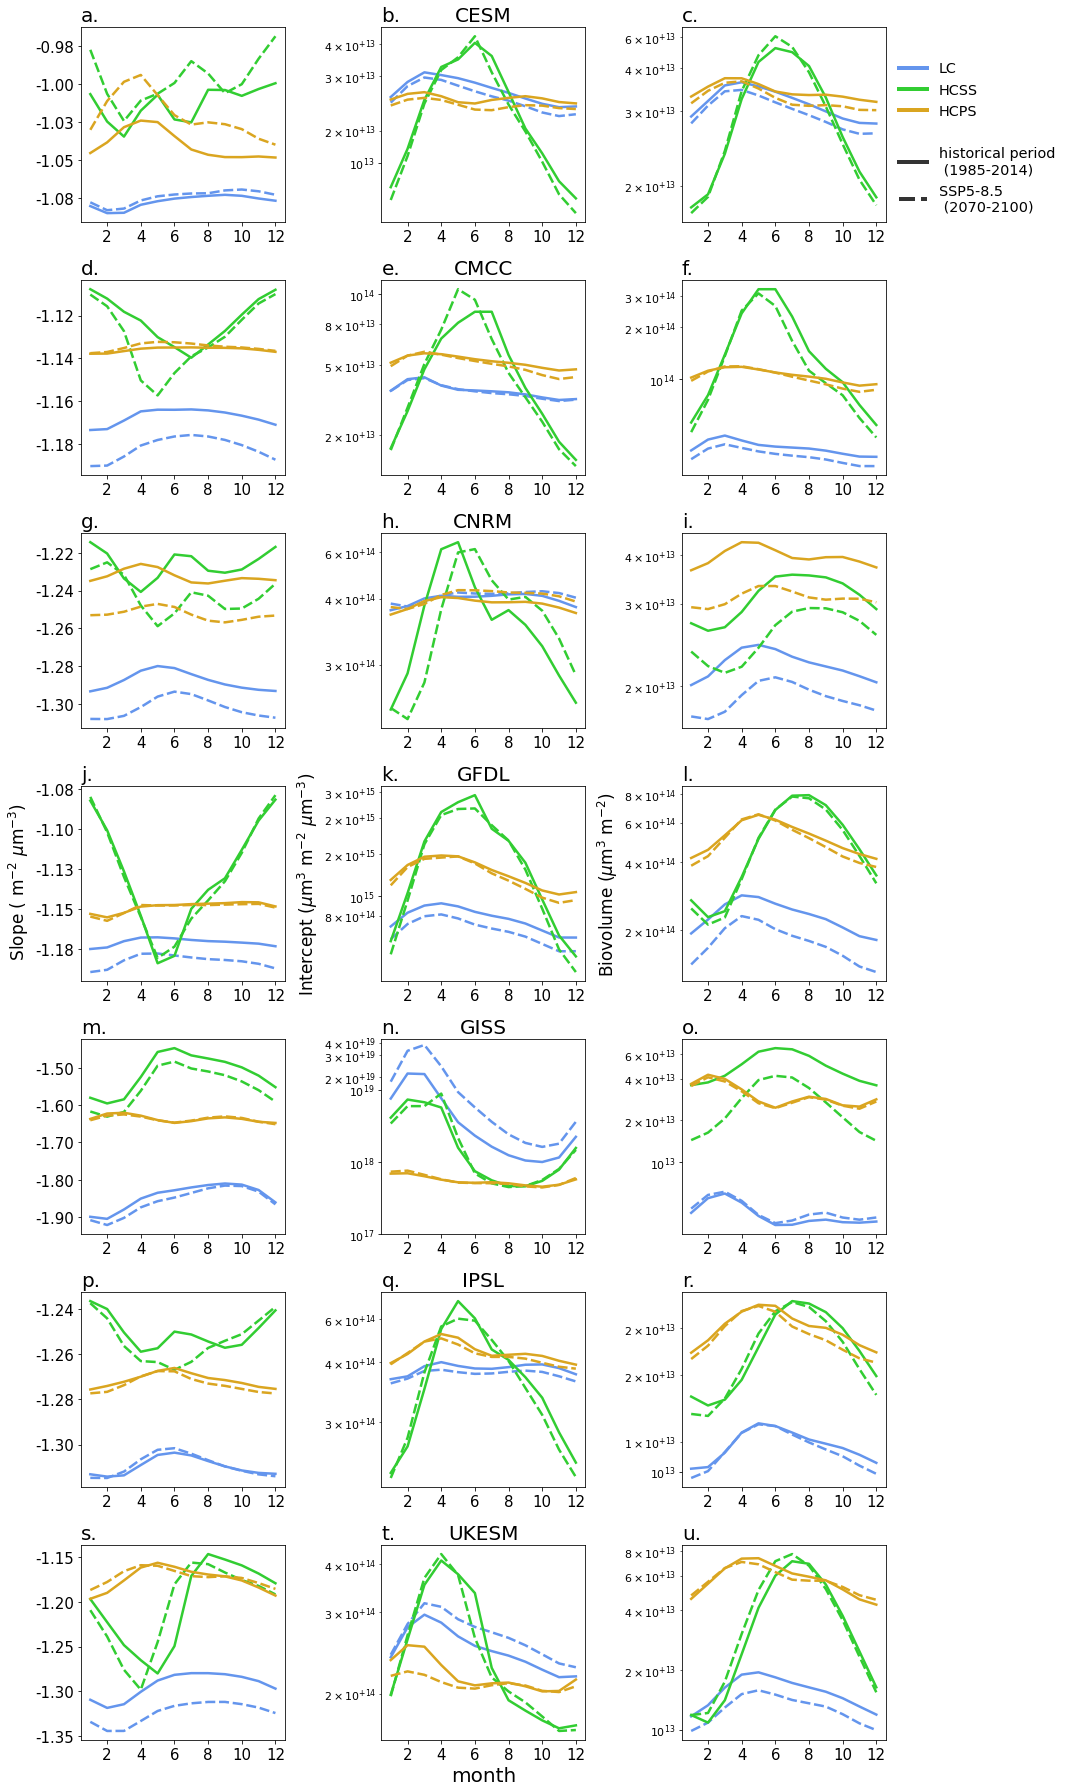

In [8]:
from matplotlib.ticker import MaxNLocator
model_list = ['CESM', 'CMCC', 'CNRM', 'GFDL', 'GISS', 'IPSL', 'UKESM']
palette = dict(LC= 'cornflowerblue', HCSS= 'limegreen', HCPS= 'goldenrod')
fig, axs = plt.subplots(nrows=7, ncols=3, figsize=(15,25))
variables = ['slope', 'intercept', 'total_biovolume']
ind=0
for r, m in enumerate(model_list):
    #print(r)
    for c, var in enumerate(variables):
        #print(c)
        ind +=1
        ax_n = axs[r,c]
        clim=sns.lineplot(ax = ax_n,x = 'month', y=var,hue = 'biomes',palette=palette, style = 'experiment', style_order=['hist','ssp5'],linewidth = 2.5, data=df_climatology_full [df_climatology_full ['source']== m]).set(title= (var + ' for model ' + m + ' by biome'))
        ax_n.tick_params(axis='both', which='major', labelsize=15)
        ax_n.set_title(letters[ind-1], loc='left', fontsize=20)
        #ax_n.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        if c == 1:
            ax_n.set_title(m, fontsize=20)
        else:
            ax_n.set_title('')
        if r ==6 and c ==1:
            ax_n.set_xlabel('month', fontsize=20)
        else:
            ax_n.set_xlabel('', fontsize=20)

        if var == 'slope':
            ax_n.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            if r ==3:
                ax_n.set_ylabel(r' Slope ( m$^{-2}$ $\mu$m$^{-3}$)', fontsize = 17)
            else:
                ax_n.set_ylabel('')
            
        elif var=='intercept':
            ax_n.set_yscale('log')
            #ax_n.yaxis.set_major_formatter(FormatStrFormatter('%.1f')
            if r ==3:
                ax_n.set_ylabel(r'Intercept ($\mu$m$^{3}$ m$^{-2}$ $\mu$m$^{-3}$)', fontsize = 17)
            else:
                ax_n.set_ylabel('')
        elif var=='total_biovolume' and r==3:
            ax_n.set_ylabel(r'Biovolume ($\mu$m$^{3}$ m$^{-2}$)', fontsize = 17)
        else:
            ax_n.set_ylabel('')
            #ax_n.set_yscale('log')
        if r ==0 and c ==2:
            L=ax_n.legend()
            L.get_texts()[5].set_text('historical period \n (1985-2014)')
            L = ax_n.legend(title='', fontsize = 'x-large',  markerscale=10, frameon=False, bbox_to_anchor=(1, 1))
            L.get_texts()[0].set_text('')
            L.get_texts()[4].set_text('')
            L.get_texts()[5].set_text('historical period \n (1985-2014)')
            L.get_texts()[6].set_text('SSP5-8.5 \n (2070-2100)')
            for line in L.get_lines():
                line.set_linewidth(4.0)
        else:
            ax_n.get_legend().remove()
        
        if c==1 or c==2:
            #ax_n.ticklabel_format(axis='y', style='scientific')
            ax_n.set_yscale('log')
            ax_n.get_yaxis().set_minor_formatter(plt.LogFormatter(10,  labelOnlyBase=False))
            ax_n.yaxis.set_minor_formatter(tick.FuncFormatter(y_fmt))
            #ax_n.yaxis.set_major_locator(plt.MaxNLocator(0))
            ax_n.yaxis.set_minor_locator(plt.MaxNLocator(4))
            ax_n.tick_params(axis='y', which='major', labelsize=11)
            ax_n.tick_params(axis='y', which='minor', labelsize=11)# rotation=90

        #ax_n.xaxis.set_major_locator(plt.MaxNLocator(0))
        ax_n.xaxis.set_major_locator(MaxNLocator(integer=True))
        if m == 'GISS' and c==1:
            ax_n.set_ylim(1e17, 5e19)


        
            
plt.tight_layout()
plt.savefig('/work/m1c/CMIP6_size_spectra_scripts/plots/fig_biomes_climatology_biovolume.pdf', dpi=300)